### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

### Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import copy
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])


In [3]:

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta))



In [13]:
# Save g2o file
def saveg2o(x, y, theta, target_file):
    lcfile="data/edges.txt" 
    f1 = open(target_file, "w")
    for i in range(len(x)):
        f1.write("VERTEX_SE2" + " " + str(i) + " " + str(x[i]) + " " + str(y[i]) + " " + str(theta[i]) + "\n")
    
    f2 = open(lcfile, "r")
    lines = f2.readlines()
    for i in range(1, len(lines)):
        if lines[i][0:3] != "FIX":
            f1.write(lines[i])

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()



In [11]:
ls

A2_Section3.ipynb  data/  examples/  misc/  parts/


[[-5.]
 [-8.]
 [ 0.]]


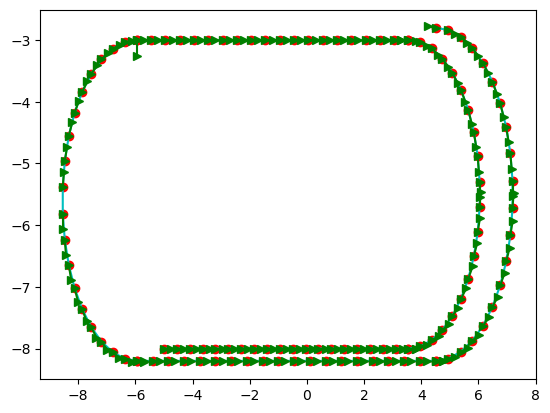

120
120


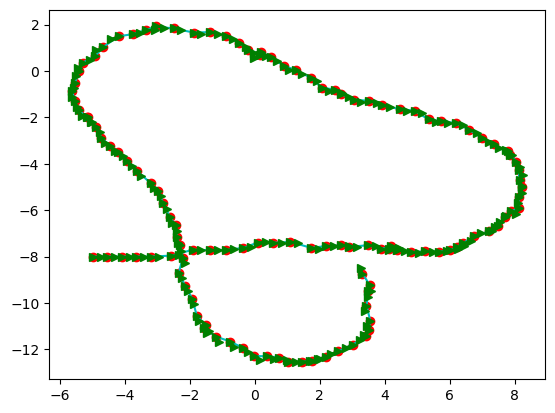

In [28]:
init = []
init = readVertex("data/edges.txt")
print(init)


x_g,y_g,theta_g = readVertex("data/gt.txt")
draw(x_g,y_g,theta_g)
print(np.size(x_g))
x = np.zeros(120)
y = np.zeros(120)
theta = np.zeros(120)
x[0] = init[0]
y[0] = init[1]
theta[0] = init[2]

ind1 = []
ind2 = []
dx = []
dy = []
dtheta = []
ind1, ind2, dx, dy, dtheta = readEdge("data/edges.txt")

for i in range(119):
    x[i+1] = x[i] + dx[i]*np.cos(theta[i]) - dy[i]*np.sin(theta[i])
    y[i+1] = y[i] + dx[i]*np.sin(theta[i]) + dy[i]*np.cos(theta[i])
    theta[i+1] = theta[i] + dtheta[i]
print(np.size(x))
draw(x,y,theta)
saveg2o(x,y,theta,"results/edges-poses.g2o")

In [22]:
def resdl(x,y,theta,dx,dy,dtheta):
    # Found fx!!!
    fx = np.zeros(420)
    for i,j in zip(range(0, 354, 3),range(119)):
        fx[i] = x[j] + dx[j]*np.cos(theta[j]) - dy[j]*np.sin(theta[j]) - x[j+1]
        fx[i+1] = y[j] + dx[j]*np.sin(theta[j]) + dy[j]*np.cos(theta[j]) - y[j+1]
        fx[i+2] = dtheta[j] + theta[j] - theta[j+1]

    for i,j,z in zip(range(357, 417, 3),range(0, 40, 2), range(119,139,1)):
        fx[i] = x[j] + dx[z]*np.cos(theta[j]) - dy[z]*np.sin(theta[j]) - x[j+80] 
        fx[i+1] = y[j] + dx[z]*np.cos(theta[j]) + dy[z]*np.sin(theta[j]) - y[j+80]
        fx[i+2] = theta[j] + dtheta[z] - theta[j+80]
    
    fx[417] = x[0] - (-5);
    fx[418] = y[0] - (-8);
    fx[419] = theta[0] - 0;
    return fx

In [23]:
def jacobian(theta,dx,dy):
    J = np.zeros((420,360))
    for i in range(119):
        J[3*i][i] = 1
        J[3*i][i+1] = -1
    
        J[3*i + 1][i+120] = 1
        J[3*i + 1][i+1+120] = -1
    
        J[3*i][i+240] = -dx[i]*np.sin(theta[i])-dy[i]*np.cos(theta[i])
        J[3*i+1][i+240] = -dy[i]*np.sin(theta[i])+dx[i]*np.cos(theta[i])
    
        J[3*i+2][i+240] = 1
        J[3*i+2][i+1+240] = -1
    
    for i,j,z in zip(range(357,417,3),range(0,40,2),range(119,139,1)):
        J[i][j] = 1
        J[i][j+80] = -1
    
        J[i+1][j+120] = 1
        J[i+1][j+80+120] = -1
    
        J[i][j+240] = -dx[z]*np.sin(theta[j])-dy[z]*np.cos(theta[j])
        J[i+1][j+240] = -dy[z]*np.sin(theta[j])+dx[z]*np.cos(theta[j])
    
        J[i+2][j+240] = 1
        J[i+2][j+80+240] = -1
    
    J[417][0] = 1
    J[418][120] = 1
    J[419][240] = 1
    
    #print(J[358][240])
    #print(theta[0])
    #plt.imshow(J)
    return J

In [24]:
omega = np.zeros((420,420))
for i in range(420):
    if i < 357:
        omega[i][i] = 500
    elif i < 417 and i >= 357:
        omega[i][i] = 700
    else:
        omega[i][i] = 1000

#print(omega[356])

In [25]:
def draw_err(itr,error, opt, num):
    plt.plot(itr, error)
    plt.xlabel('iterations')
    plt.ylabel('logarithm of Error')
    plt.title('Error vs Iterations for ' + opt + ' ' + str(num) + ' iterations')
    plt.grid(True)
    plt.show()

### Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [19]:
def draw_all(X, Y, THETA, opt, itr):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    ax.plot(x_g, y_g, 'ro')
    plt.plot(x_g, y_g, 'c-')

    for i in range(len(theta_g)):
        x2 = 0.25*math.cos(theta_g[i]) + x_g[i]
        y2 = 0.25*math.sin(theta_g[i]) + y_g[i]
        plt.plot([x_g[i], x2], [y_g[i], y2], 'y->')
    
    ax.plot(x, y, 'ro')
    plt.plot(x, y, 'c-')

    for i in range(len(theta)):
        x2 = 0.25*math.cos(theta[i]) + x[i]
        y2 = 0.25*math.sin(theta[i]) + y[i]
        plt.plot([x[i], x2], [y[i], y2], 'r->')
    
    plt.title('2D SLAM for ' + opt + ' ' + str(itr) + ' iterations')
    plt.grid(True)
    plt.show()

In [26]:
def omega_func(odo,lc,anc):
    omega = np.zeros((420,420))
    for i in range(420):
        if i < 357:
            omega[i][i] = odo
        elif i < 417 and i >= 357:
            omega[i][i] = lc
        else:
            omega[i][i] = anc
    return omega

0 20645.6093063578 27087.219360189512
1 9601.302596079375 11044.306710278426
2 7279.842815816297 2321.459780263078
3 5435.20427668544 1844.6385391308568
4 3946.8842551899625 1488.3200214954777
5 2610.1012534514907 1336.7830017384717
6 2004.6437637082126 605.4574897432781
7 1796.0698352902205 208.5739284179922
8 1674.0993606621935 121.97047462802698
9 1592.1235840435238 81.97577661866967
10 1530.8884043718892 61.23517967163457
11 1480.5666168529315 50.32178751895776
12 1436.0527783708212 44.51383848211026
13 1394.8808429667235 41.17193540409767
14 1356.1508117232386 38.73003124348497
15 1319.7469963439746 36.40381537926396
16 1285.6095304337346 34.13746591024005
17 1253.293314383977 32.316216049757486
18 1222.0110794850254 31.28223489895163
19 1190.9638325823396 31.047246902685856
20 1159.6454167596055 31.318415822734096
21 1127.9933567955688 31.652059964036653
22 1096.3800040877186 31.613352707850254
23 1065.456944284621 30.923059803097658
24 1035.906927014932 29.55001726968885
25 1008

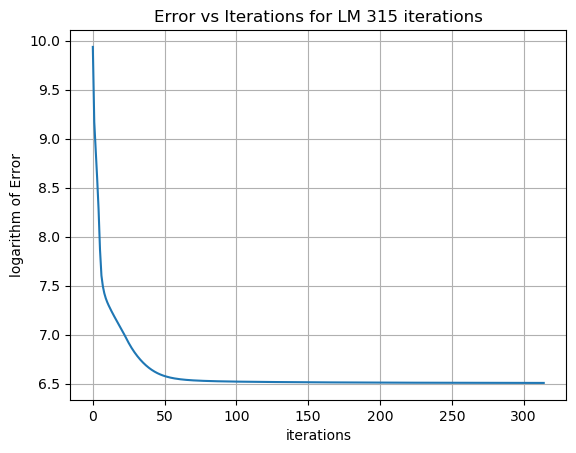

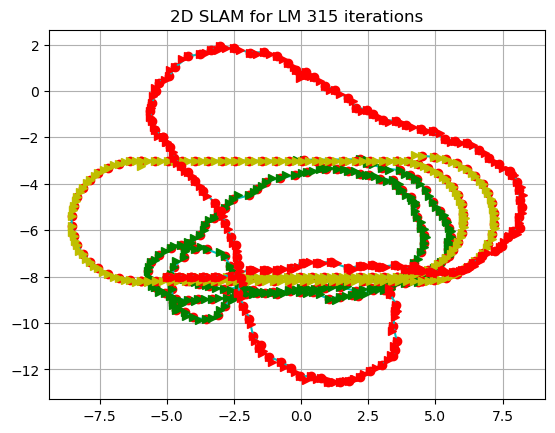

In [27]:
omega = omega_func(700,50,1000)
def lm(x,y,theta,dx,dy,dtheta):
    del_error = 0.01
    itr = []
    err_val = []
    fx = resdl(x,y,theta,dx,dy,dtheta)
    prev_err=0.5*np.dot(np.dot(fx.T,omega),fx)

    for i in range(5000):
        lam = 1
        fx = resdl(x,y,theta,dx,dy,dtheta)
        J = jacobian(theta,dx,dy)

        dx1 = (-1)*np.linalg.inv(np.dot(np.dot(J.T,omega),J) + lam*np.identity(360))
        dx1 = np.dot(dx1,np.dot(np.dot(J.T,omega.T),fx))

        dxx = dx1[:120]
        dxy = dx1[120:240]
        dxz = dx1[240:]

        final_x = x + dxx
        final_y = y + dxy
        final_theta = theta + dxz
        new_fx = resdl(final_x, final_y, final_theta, dx, dy, dtheta)
    
        new_err=0.5*np.dot(np.dot(new_fx.T,omega),new_fx)
        
        if abs(prev_err-new_err)<del_error:
            print("Converged")
            break
        if new_err<prev_err:
            lam/=10
            x,y,theta = final_x,final_y,final_theta
            print(i, new_err, abs(prev_err-new_err) )
            prev_err=new_err
        else:
            lam*=10
            print(i, new_err, abs(prev_err-new_err))
        itr.append(i)
        err_val.append(new_err)
    
    err_val = np.log(err_val)
    draw_err(itr, err_val, 'LM', len(itr))
    draw_all(final_x,final_y,final_theta, 'LM', len(itr))
    
lm(x,y,theta,dx,dy,dtheta)
# Plot 10 plots for i = 10, i = 20, i = 5, i = 30, i = 50, i = 100, i = 150, i = converged

### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.